В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [135]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import PolynomialFeatures

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import TomekLinks

Train f1: 0.6538009733176707, auc: 0.816775558300982
Area under ROC score on Train dataset: 0.82%


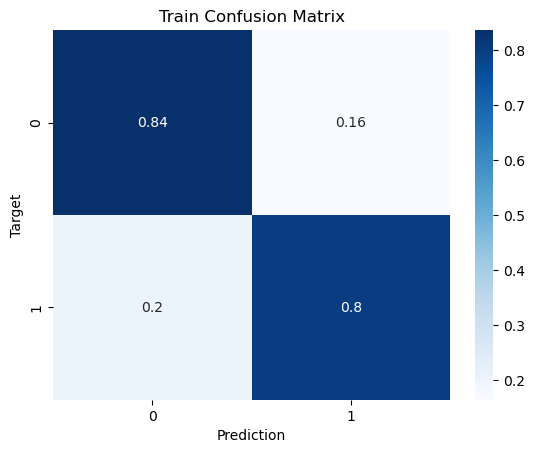

Validation f1: 0.6416072585871678, auc: 0.8141059057548529
Area under ROC score on Validation dataset: 0.81%


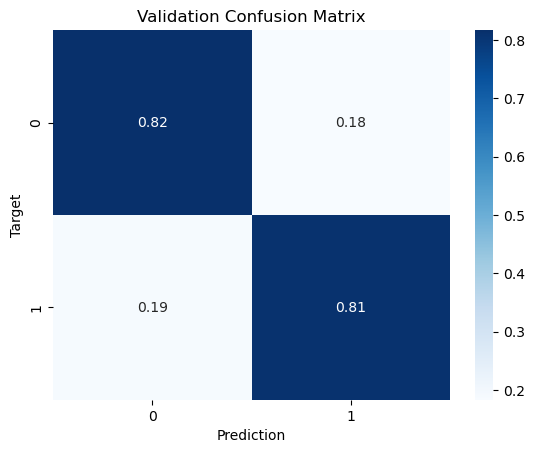

In [4]:
path = "../../../data/"
raw_df = pd.read_csv(path + "train.csv", index_col=0)

# # Створюємо трен. і вал. набори
train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df['Exited'])

input_cols = raw_df.drop(columns=['Exited']).columns.tolist()
train_inputs = train_df[input_cols].copy()
val_inputs = val_df[input_cols].copy()

target_col = 'Exited'
train_targets = train_df[target_col].copy()
val_targets = val_df[target_col].copy()

# Виділення категоріальних і числових колонок
numeric_cols = train_df[input_cols].select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove('CustomerId')

categorical_cols = train_df[input_cols].select_dtypes(include='object').columns.tolist()
categorical_cols.remove('Surname')

# # Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[ 
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop = 'if_binary'))
])


# # Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
])

# # Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampling', SMOTE(random_state=0)),
    ('classifier', LogisticRegression())
])

model_pipeline.fit(train_inputs, train_targets)


# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    f1 = f1_score(targets, preds)
    roc_auc = roc_auc_score(targets, preds)   
    print(f'{name} f1: {f1}, auc: {roc_auc}')

    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')





**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

In [32]:
from imblearn.combine import SMOTETomek

In [33]:
def create_polinom_pipline(degree, sample_model = SMOTE(), model = LogisticRegression()):
    # # Створюємо трансформери для числових і категоріальних колонок
    numeric_transformer_pol = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('polynom', PolynomialFeatures(degree=degree)),
    ])

    # # Комбінуємо трансформери для різних типів колонок в один препроцесор
    preprocessor_pol = ColumnTransformer(
        transformers = [
            ('num', numeric_transformer_pol, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
    ])

    model_pipeline_pol = Pipeline(steps=[
        ('preprocessor', preprocessor_pol),
        ('sampling', sample_model),
        ('classifier', model)
    ])
    return model_pipeline_pol


In [34]:
def predict_and_plot(model_pipeline, inputs, targets, degree, model, name=''):
    preds = model_pipeline.predict(inputs)
    f1 = f1_score(targets, preds)
    roc_auc = roc_auc_score(targets, preds)   
    print(f'degree={degree}, model {model}')
    # print(f'{name}, degree={degree}, model {model} f1: {f1:0.4}, auc: {roc_auc:.04}', )

    return preds


In [15]:
samplers = {TomekLinks(random_state=0), SMOTETomek(random_state=0), SMOTE(random_state=0), ADASYN(random_state=0)}
models = {LogisticRegression()}
degrees = {1, 2, 3, 4}

In [19]:
results = []
for sampler in samplers:
    for model in models:
        for degree in degrees:
            model_pipeline_regress = create_polinom_pipline(degree,sampler, model)
            model_pipeline_regress.fit(train_inputs, train_targets)

            y_train = model_pipeline_regress.predict(train_inputs)
            y_val = model_pipeline_regress.predict(val_inputs)

            train_preds= predict_and_plot(model_pipeline_regress, train_inputs, train_targets, degree, model, 'Train')
            val_preds = predict_and_plot(model_pipeline_regress, val_inputs,val_targets, degree, model, 'Validation')

            y_train = model_pipeline_regress.predict(train_inputs)
            y_val = model_pipeline_regress.predict(val_inputs)

            # Calculate metrics for train set
            f1_train = f1_score(train_targets, y_train)
            auc_train = roc_auc_score(train_targets, y_train)
            f1_val = f1_score(val_targets, y_val)
            auc_val = roc_auc_score(val_targets, y_val)
            results.append({
                'degree': {degree, sampler},
                'model': type(model).__name__,
                'f1 train': f1_train,
                'roc_auc train ': auc_train,
                'f1 val': f1_val,
                'roc_auc val': auc_val
            })

            test_raw_df = pd.read_csv(path + 'test.csv')
            test_pol2 = test_raw_df.copy()
            preds_2 = model_pipeline_regress.predict_proba(test_raw_df)[:,1]
            test_pol2['Exited'] = preds_2
            
            name = f'submission_log_pol{degree}_{model}_{sampler}.csv'

            submit_pol2 = pd.read_csv(path + 'sample_submission.csv')
            submit_pol2['Exited'] = test_pol2['Exited']
            
            submit_pol2.to_csv(path + name, index=False)
            # submit_pol4.to_csv(path + 'submission_log_pol4_minmax.csv', index=False)
                
        


# Convert results to a DataFrame
results_df = pd.DataFrame(results)

degree=1, model LogisticRegression()
degree=1, model LogisticRegression()


c:\Users\Olha Shaposhnyk\anaconda3\envs\ml_course\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


degree=2, model LogisticRegression()
degree=2, model LogisticRegression()


c:\Users\Olha Shaposhnyk\anaconda3\envs\ml_course\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


degree=3, model LogisticRegression()
degree=3, model LogisticRegression()


c:\Users\Olha Shaposhnyk\anaconda3\envs\ml_course\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


degree=4, model LogisticRegression()
degree=4, model LogisticRegression()
degree=1, model LogisticRegression()
degree=1, model LogisticRegression()
degree=2, model LogisticRegression()
degree=2, model LogisticRegression()
degree=3, model LogisticRegression()
degree=3, model LogisticRegression()


c:\Users\Olha Shaposhnyk\anaconda3\envs\ml_course\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


degree=4, model LogisticRegression()
degree=4, model LogisticRegression()


In [20]:
results_df

,degree,model,f1 train,roc_auc train,f1 val,roc_auc val
0,"{SMOTETomek(), 1}",LogisticRegression,0.652822,0.816405,0.641656,0.814507
1,"{SMOTETomek(), 2}",LogisticRegression,0.704259,0.849309,0.697235,0.849294
2,"{SMOTETomek(), 3}",LogisticRegression,0.711788,0.854059,0.704762,0.853042
3,"{SMOTETomek(), 4}",LogisticRegression,0.717440,0.857219,0.708966,0.853111
4,"{1, TomekLinks()}",LogisticRegression,0.653565,0.766427,0.657825,0.773746
5,"{2, TomekLinks()}",LogisticRegression,0.711819,0.802444,0.705263,0.802730
6,"{TomekLinks(), 3}",LogisticRegression,0.737188,0.821525,0.727429,0.819525
7,"{TomekLinks(), 4}",LogisticRegression,0.744819,0.828869,0.737733,0.828925


In [22]:
results_df.to_csv(path +'results_all_combination.csv', index=False)

In [ ]:
test_raw_df = pd.read_csv(path + 'test.csv')
test_pol2 = test_raw_df.copy()
preds_2 = model_pipeline_regress.predict_proba(test_raw_df)[:,1]
test_pol2['Exited'] = preds_2

submit_pol2 = pd.read_csv(path + 'sample_submission.csv')
submit_pol2['Exited'] = test_pol2['Exited']


# submit_pol2.to_csv(path + 'submission_log_pol5_minmax.csv', index=False)


In [128]:
# smote = SMOTE(random_state=0)
# model_pipeline_pol2_s2 = create_polinom_pipline(degree = 6, sample_model = smote)
# model_pipeline_pol2_s2.fit(train_inputs, train_targets)

# # Оцінюємо модель на трен і вал даних
# train_preds_pol2_s2 = predict_and_plot(model_pipeline_pol2_s2, train_inputs, train_targets, 'Train')
# val_preds_pol2_s2 = predict_and_plot(model_pipeline_pol2_s2, val_inputs, val_targets, 'Validation')

In [129]:
# model_pipeline_pol2_s3 = create_polinom_pipline(degree = 3, sample_model = smote)
# model_pipeline_pol2_s3.fit(train_inputs, train_targets)

# # Оцінюємо модель на трен і вал даних
# train_preds_pol2_s3 = predict_and_plot(model_pipeline_pol2_s3, train_inputs, train_targets, 'Train')
# val_preds_pol2_s3 = predict_and_plot(model_pipeline_pol2_s3, val_inputs, val_targets, 'Validation')

In [130]:
# adasyn = ADASYN(random_state=0)
# model_pipeline_pol_a2 = create_polinom_pipline(degree = 2, sample_model = adasyn)
# model_pipeline_pol_a2.fit(train_inputs, train_targets)

# # Оцінюємо модель на трен і вал даних
# train_preds_pol_a2 = predict_and_plot(model_pipeline_pol_a2, train_inputs, train_targets, 'Train')
# val_preds_pol_a2 = predict_and_plot(model_pipeline_pol_a2, val_inputs, val_targets, 'Validation')

In [131]:
# model_pipeline_pol_a3 = create_polinom_pipline(degree = 3, sample_model = adasyn)
# model_pipeline_pol_a3.fit(train_inputs, train_targets)

# # Оцінюємо модель на трен і вал даних
# train_preds_pol_a3 = predict_and_plot(model_pipeline_pol_a3, train_inputs, train_targets, 'Train')
# val_preds_pol2_a3 = predict_and_plot(model_pipeline_pol_a3, val_inputs, val_targets, 'Validation')

In [132]:
# model_pipeline_pol2_s2
# model_pipeline_pol2_s3

# model_pipeline_pol_a2
# model_pipeline_pol_a3

In [133]:
# test_raw_df = pd.read_csv(path + 'test.csv')
# test_pol2 = test_raw_df.copy()
# preds_2 = model_pipeline_pol_a3.predict_proba(test_raw_df)[:,1]
# test_pol2['Exited'] = preds_2

# submit_pol2 = pd.read_csv(path + 'sample_submission.csv')
# submit_pol2['Exited'] = test_pol2['Exited']



# submit_pol2.to_csv(path + 'submission_log_pol3_adasyn.csv', index=False)
# submit_pol4.to_csv(path + 'submission_log_pol4_minmax.csv', index=False)

In [122]:
df_original = pd.read_csv(path + 'Churn_Modelling.csv')
df_original.dropna(inplace=True)

In [123]:
df_original.shape
df_combine = pd.concat([df_original[df_original['Exited'] == 1], raw_df], axis=0)


In [124]:
df_combine.Exited.value_counts()

Exited
0.0    11948
1.0     5090
Name: count, dtype: int64

In [125]:
train_df, val_df = train_test_split(df_combine, test_size=0.2, random_state=12, stratify=df_combine['Exited'])

input_cols = df_combine.drop(columns=['Exited']).columns.tolist()
train_inputs = train_df[input_cols].copy()
val_inputs = val_df[input_cols].copy()

target_col = 'Exited'
train_targets = train_df[target_col].copy()
val_targets = val_df[target_col].copy()

# Виділення категоріальних і числових колонок
numeric_cols = train_df[input_cols].select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove('CustomerId')

categorical_cols = train_df[input_cols].select_dtypes(include='object').columns.tolist()
categorical_cols.remove('Surname')

In [126]:
from sklearn.impute import KNNImputer, SimpleImputer

In [137]:
def create_full_pipline(degree, sample_model = '', model = LogisticRegression()):
    # # Створюємо трансформери для числових і категоріальних колонок
    numeric_transformer_pol = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('imputer', KNNImputer()),
        ('polynom', PolynomialFeatures(degree=degree)),
    ])

    categorical_transformer = Pipeline(steps=[ 
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop = 'if_binary'))
    ])

    # # Комбінуємо трансформери для різних типів колонок в один препроцесор
    preprocessor_pol = ColumnTransformer(
        transformers = [
            ('num', numeric_transformer_pol, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
    ])
    
    if sample_model == 'Raw':
        model_pipeline_pol = Pipeline(steps=[
            ('preprocessor', preprocessor_pol),
            ('classifier', model)
        ])
    else:
        model_pipeline_pol = Pipeline(steps=[
            ('preprocessor', preprocessor_pol),
            ('sampling', sample_model),
            ('classifier', model)
    ])
    return model_pipeline_pol

In [138]:
samplers = {TomekLinks(), SMOTETomek(random_state=0), SMOTE(random_state=0), ADASYN(random_state=0), 'Raw'}
models = {LogisticRegression()}
degrees = {1, 2, 3}

In [139]:
results = []
for sampler in samplers:
    for model in models:
        for degree in degrees:
            model_pipeline_regress = create_full_pipline(degree, sampler, model)
            model_pipeline_regress.fit(train_inputs, train_targets)

            y_train = model_pipeline_regress.predict(train_inputs)
            y_val = model_pipeline_regress.predict(val_inputs)

            train_preds= predict_and_plot(model_pipeline_regress, train_inputs, train_targets, degree, model, 'Train')
            val_preds = predict_and_plot(model_pipeline_regress, val_inputs,val_targets, degree, model, 'Validation')

            y_train = model_pipeline_regress.predict(train_inputs)
            y_val = model_pipeline_regress.predict(val_inputs)

            # Calculate metrics for train set
            f1_train = f1_score(train_targets, y_train)
            auc_train = roc_auc_score(train_targets, y_train)
            f1_val = f1_score(val_targets, y_val)
            auc_val = roc_auc_score(val_targets, y_val)
            results.append({
                'degree': {degree, sampler, 'STANDART_only_1'},
                'model': type(model).__name__,
                'f1 train': f1_train,
                'roc_auc train ': auc_train,
                'f1 val': f1_val,
                'roc_auc val': auc_val
            })

            test_raw_df = pd.read_csv(path + 'test.csv')
            test_pol2 = test_raw_df.copy()
            preds_2 = model_pipeline_regress.predict_proba(test_raw_df)[:,1]
            test_pol2['Exited'] = preds_2
            
            name = f'submission_log_pol{degree}_{model}_{sampler}_STANDART_only_1.csv'

            submit_pol2 = pd.read_csv(path + 'sample_submission.csv')
            submit_pol2['Exited'] = test_pol2['Exited']
            
            submit_pol2.to_csv(path + 'results/' + name, index=False)



# Convert results to a DataFrame
results_df = pd.DataFrame(results)
results_df.to_csv(path +'results_all_combination_fullpipeline_STANDART_only_1.csv', index=False)

degree=1, model LogisticRegression()
degree=1, model LogisticRegression()
degree=2, model LogisticRegression()
degree=2, model LogisticRegression()


c:\Users\Olha Shaposhnyk\anaconda3\envs\ml_course\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


degree=3, model LogisticRegression()
degree=3, model LogisticRegression()
degree=1, model LogisticRegression()
degree=1, model LogisticRegression()
degree=2, model LogisticRegression()
degree=2, model LogisticRegression()
degree=3, model LogisticRegression()
degree=3, model LogisticRegression()
degree=1, model LogisticRegression()
degree=1, model LogisticRegression()
degree=2, model LogisticRegression()
degree=2, model LogisticRegression()
degree=3, model LogisticRegression()
degree=3, model LogisticRegression()
degree=1, model LogisticRegression()
degree=1, model LogisticRegression()
degree=2, model LogisticRegression()
degree=2, model LogisticRegression()


c:\Users\Olha Shaposhnyk\anaconda3\envs\ml_course\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


degree=3, model LogisticRegression()
degree=3, model LogisticRegression()
degree=1, model LogisticRegression()
degree=1, model LogisticRegression()
degree=2, model LogisticRegression()
degree=2, model LogisticRegression()
degree=3, model LogisticRegression()
degree=3, model LogisticRegression()


In [140]:
path + 'results/'

'../../../data/results/'

In [141]:
results_df

,degree,model,f1 train,roc_auc train,f1 val,roc_auc val
0,"{1, SMOTETomek(random_state=0), STANDART_only_1}",LogisticRegression,0.706537,0.798728,0.676718,0.775591
1,"{STANDART_only_1, 2, SMOTETomek(random_state=0)}",LogisticRegression,0.787008,0.859614,0.769441,0.845437
2,"{STANDART_only_1, 3, SMOTETomek(random_state=0)}",LogisticRegression,0.806696,0.872757,0.783985,0.853305
3,"{SMOTE(random_state=0), 1, STANDART_only_1}",LogisticRegression,0.707456,0.799392,0.677032,0.775728
4,"{SMOTE(random_state=0), STANDART_only_1, 2}",LogisticRegression,0.787742,0.860299,0.768881,0.844946
5,"{SMOTE(random_state=0), STANDART_only_1, 3}",LogisticRegression,0.807042,0.873498,0.786840,0.856115
6,"{1, TomekLinks(), STANDART_only_1}",LogisticRegression,0.694495,0.778111,0.673278,0.763869
7,"{STANDART_only_1, 2, TomekLinks()}",LogisticRegression,0.797054,0.852991,0.779849,0.839781
8,"{STANDART_only_1, TomekLinks(), 3}",LogisticRegression,0.809429,0.861782,0.792947,0.848885
9,"{1, ADASYN(random_state=0), STANDART_only_1}",LogisticRegression,0.692372,0.792285,0.670870,0.774163
